In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
try:
    import polyline
except ModuleNotFoundError:
    !pip install polyline
    import polyline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('.'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = "drive/My Drive/hack/CityMobil/"

In [0]:
# old_data_path = path + ' old_data/'
# path = old_data_path

In [125]:
!ls ./drive/My\ Drive/hack/CityMobil/\ old_data

test_additional.csv  test.csv	      train.csv       valid_clean.csv
test_clean.csv	     train_clean.csv  validation.csv


## Reading data

In [0]:
train = pd.read_csv(path + 'train.csv', index_col=0)

In [0]:
valid = pd.read_csv(path + 'validation.csv', index_col=0)

In [0]:
test = pd.read_csv(path + 'test_additional.csv', index_col=0)

In [129]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837128 entries, 0 to 831223
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   main_id_locality    837128 non-null  int64  
 1   ETA                 837128 non-null  float64
 2   RTA                 837128 non-null  float64
 3   OrderedDate         837128 non-null  object 
 4   latitude            837128 non-null  float64
 5   del_latitude        837128 non-null  float64
 6   longitude           837128 non-null  float64
 7   del_longitude       837128 non-null  float64
 8   EDA                 837128 non-null  float64
 9   RDA                 837128 non-null  float64
 10  ReadyForCollection  837128 non-null  object 
 11  ClientCollected     837128 non-null  object 
 12  GoodArrived         837128 non-null  object 
 13  ready_latitude      834220 non-null  float64
 14  ready_longitude     834220 non-null  float64
 15  onway_latitude      834220 non-nul

In [130]:
test.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            89928, 89929, 89930, 89931, 89932, 89933, 89934, 89935, 89936,
            89937],
           dtype='int64', name='Id', length=89938)

### Checking data

In [0]:
def search_na(df):
    na_cols = list()
    for col in df:
        nas = df[col].isna().sum()
        if nas:
            na_cols.append(col)
            print(f"In {col} - {nas} NaNs")
    return na_cols

In [0]:
# First let's drop for first time experimental columns with NaNs and RDA column
def df_transform(df, na_cols):
    time_feat = ['OrderedDate', 'ReadyForCollection', 'ClientCollected', 'GoodArrived']
    for col in df:
        if col in time_feat:
            df[col] = pd.to_datetime(df[col])
    drop_cols = ['RDA', 'track', 'GoodArrived', 'ready_latitude',
                 'ready_longitude', 'onway_latitude', 'onway_longitude',
                 'arrived_latitude', 'arrived_longitude']
    for col in drop_cols:
      if col in df:
        df = df.drop(columns=col)
    # del df
    return df

In [133]:
na_cols = list(set(search_na(train) + search_na(valid) + search_na(test)))
train = df_transform(train, na_cols)
valid = df_transform(valid, na_cols)
test = df_transform(test, na_cols)

In ready_latitude - 2908 NaNs
In ready_longitude - 2908 NaNs
In onway_latitude - 2908 NaNs
In onway_longitude - 2908 NaNs
In arrived_latitude - 2908 NaNs
In arrived_longitude - 2908 NaNs
In route - 15875 NaNs
In track - 50408 NaNs
In ready_latitude - 307 NaNs
In ready_longitude - 307 NaNs
In onway_latitude - 307 NaNs
In onway_longitude - 307 NaNs
In arrived_latitude - 307 NaNs
In arrived_longitude - 307 NaNs
In route - 706 NaNs
In ready_latitude - 287 NaNs
In ready_longitude - 287 NaNs
In onway_latitude - 287 NaNs
In onway_longitude - 287 NaNs
In arrived_latitude - 287 NaNs
In arrived_longitude - 287 NaNs
In route - 25 NaNs


In [134]:
train.head()

,main_id_locality,ETA,RTA,OrderedDate,latitude,del_latitude,longitude,del_longitude,EDA,ReadyForCollection,ClientCollected,center_latitude,center_longitude,route
Id,,,,,,,,,,,,,,
0,1078,226.0,188.0,2020-02-12 19:12:06,55.826019,55.825581,49.134529,49.126949,1.0,2020-02-12 19:14:33,2020-02-12 19:15:06,55.794388,49.111531,gnvsIaq{jHChA??uC???OPG^F^NRzKBd@AN[r@???`@`@`...
1,1078,718.0,725.0,2020-02-12 19:12:22,55.795502,55.820911,49.131470,49.115360,5.0,2020-02-12 19:19:03,2020-02-12 19:19:42,55.794388,49.111531,sqpsI}~zjHyAr]e@lMk@fLaBlb@i@rLKhBCdAUxEGlCg@f...
2,1078,612.0,764.0,2020-02-12 19:12:44,55.791050,55.819962,49.226070,49.176628,5.0,2020-02-12 19:15:21,2020-02-12 19:15:25,55.794388,49.111531,auosI}mmkH?LHd@KhC??o@w@[g@m@iAUk@??{G|OiB`Ek@...
3,1078,1560.0,1412.0,2020-02-12 19:12:44,55.753899,55.824680,49.188519,49.093700,13.0,2020-02-12 19:19:00,2020-02-12 19:19:09,55.794388,49.111531,{lhsIiffkHmKN_C?mIPwMJ??Si@gA{B??Wq@MRCJTp@hAd...
4,1078,1528.0,893.0,2020-02-12 19:12:45,55.822361,55.786758,49.069092,49.143501,9.0,2020-02-12 19:16:32,2020-02-12 19:17:26,55.794388,49.111531,yxusI{xnjHgAfG??}IuHkAqA??pIoe@VsA??dAkG`BuH??...


In [135]:
print(train.shape[1], valid.shape[1], test.shape[1])
assert train.shape[1] == valid.shape[1]

14 14 13


In [136]:
train.columns.difference(test.columns)

Index(['RTA'], dtype='object')

### Outliers check

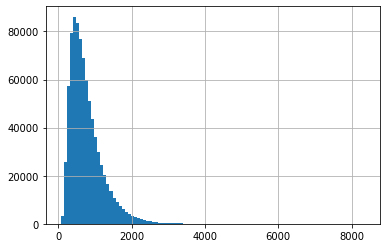

In [137]:
train.RTA.hist(bins=100)

In [0]:
rta_mu = train.RTA.append(valid.RTA, ignore_index=True).mean()
rta_std = train.RTA.append(valid.RTA, ignore_index=True).std()

In [139]:
# Dropping outliers
samples = train.shape[0]
train = train.query('RTA <= @rta_mu + 2 * @rta_std & RTA >= @rta_mu - 2 * @rta_std')
print(f"dropped outliers {samples - train.shape[0]}")

dropped outliers 38775


In [140]:
# Dropping outliers from validation
samples = valid.shape[0]
valid = valid.query('RTA <= @rta_mu + 2 * @rta_std & RTA >= @rta_mu - 2 * @rta_std')
print(f"dropped outliers {samples - valid.shape[0]}")

dropped outliers 4604


## Feature engineering

### Features from routes

In [141]:
# Transforming routes into steps
%time train['route_steps'] = train.route.apply(lambda x: len(polyline.decode(x)) if not pd.isna(x) else np.nan)

CPU times: user 1min 46s, sys: 8.08 ms, total: 1min 46s
Wall time: 1min 46s


In [142]:
# Transforming routes into steps
%time valid['route_steps'] = valid.route.apply(lambda x: len(polyline.decode(x)) if not pd.isna(x) else np.nan)

CPU times: user 14.2 s, sys: 0 ns, total: 14.2 s
Wall time: 14.2 s


In [143]:
# Transforming routes into steps
%time test['route_steps'] = test.route.apply(lambda x: len(polyline.decode(x)) if not pd.isna(x) else np.nan)

CPU times: user 14.3 s, sys: 6.38 ms, total: 14.3 s
Wall time: 14.3 s


In [0]:
median_steps = pd.concat([train.route_steps, valid.route_steps, test.route_steps], ignore_index=True).median()

In [0]:
train.route_steps.fillna(median_steps, inplace=True)
valid.route_steps.fillna(median_steps, inplace=True)
test.route_steps.fillna(median_steps, inplace=True)

### Features from cordinates

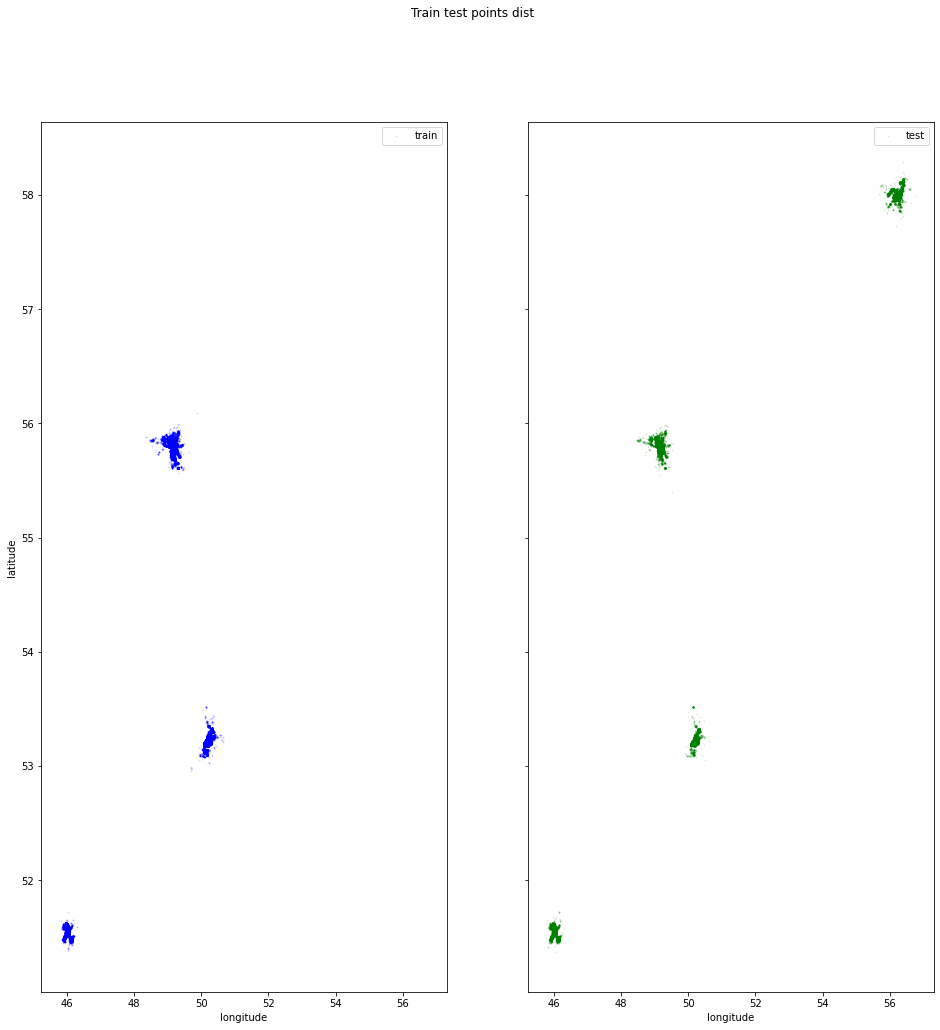

In [146]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 16))
ax[0].scatter(train['longitude'].values[:500000], train['latitude'].values[:500000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['longitude'].values[:500000], test['latitude'].values[:500000],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train test points dist')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.show()

In [0]:
# Route and distance features
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [0]:
# Function for all distance features
def add_dist_features(df):
    df['haversine_dist'] = haversine_array(df['latitude'].values, df['longitude'].values,
                                          df['del_latitude'].values, df['del_longitude'].values)
    df['manhattan_dist'] = manhattan_distance(df['latitude'].values, df['longitude'].values,
                                          df['del_latitude'].values, df['del_longitude'].values)
    df['angle'] = bearing_array(df['latitude'].values, df['longitude'].values,
                                          df['del_latitude'].values, df['del_longitude'].values)

In [149]:
%time add_dist_features(train)
%time add_dist_features(valid)
%time add_dist_features(test)

CPU times: user 368 ms, sys: 931 µs, total: 369 ms
Wall time: 369 ms
CPU times: user 47.7 ms, sys: 0 ns, total: 47.7 ms
Wall time: 47.7 ms
CPU times: user 44.7 ms, sys: 1.01 ms, total: 45.7 ms
Wall time: 45.3 ms


In [150]:
train.head()

,main_id_locality,ETA,RTA,OrderedDate,latitude,del_latitude,longitude,del_longitude,EDA,ReadyForCollection,ClientCollected,center_latitude,center_longitude,route,route_steps,haversine_dist,manhattan_dist,angle
Id,,,,,,,,,,,,,,,,,,
0,1078,226.0,188.0,2020-02-12 19:12:06,55.826019,55.825581,49.134529,49.126949,1.0,2020-02-12 19:14:33,2020-02-12 19:15:06,55.794388,49.111531,gnvsIaq{jHChA??uC???OPG^F^NRzKBd@AN[r@???`@`@`...,29.0,0.475936,0.522207,-95.879608
1,1078,718.0,725.0,2020-02-12 19:12:22,55.795502,55.820911,49.131470,49.115360,5.0,2020-02-12 19:19:03,2020-02-12 19:19:42,55.794388,49.111531,sqpsI}~zjHyAr]e@lMk@fLaBlb@i@rLKhBCdAUxEGlCg@f...,78.0,2.999397,3.832401,-19.603279
2,1078,612.0,764.0,2020-02-12 19:12:44,55.791050,55.819962,49.226070,49.176628,5.0,2020-02-12 19:15:21,2020-02-12 19:15:25,55.794388,49.111531,auosI}mmkH?LHd@KhC??o@w@[g@m@iAUk@??{G|OiB`Ek@...,79.0,4.458880,6.305716,-43.843021
3,1078,1560.0,1412.0,2020-02-12 19:12:44,55.753899,55.824680,49.188519,49.093700,13.0,2020-02-12 19:19:00,2020-02-12 19:19:09,55.794388,49.111531,{lhsIiffkHmKN_C?mIPwMJ??Si@gA{B??Wq@MRCJTp@hAd...,164.0,9.853176,13.803791,-36.946603
4,1078,1528.0,893.0,2020-02-12 19:12:45,55.822361,55.786758,49.069092,49.143501,9.0,2020-02-12 19:16:32,2020-02-12 19:17:26,55.794388,49.111531,yxusI{xnjHgAfG??}IuHkAqA??pIoe@VsA??dAkG`BuH??...,130.0,6.107029,8.606808,130.378310


In [0]:
# first_version
# train.drop(columns=['ReadyForCollection', 'ClientCollected', 'GoodArrived', 'route']).to_csv(path + 'train_clean.csv')

In [0]:
# first_version
# valid.drop(columns=['ReadyForCollection', 'ClientCollected', 'GoodArrived', 'route']).to_csv(path + 'valid_clean.csv')

### Time features

In [0]:
# First of all we need to get utc of every city
try:
    import timezonefinder
    import pytz
except ModuleNotFoundError:
    !pip install pytz
    !pip install timezonefinder
    import pytz
    import timezonefinder

In [154]:
print(f"Unique cities:{train.main_id_locality.unique()} {train.main_id_locality.nunique()}")
print(f"Unique cities:{train.center_latitude.unique()} {train.center_latitude.nunique()}")
print(f"Unique cities:{train.center_longitude.unique()} {train.center_longitude.nunique()}")

Unique cities:[ 1078 22390 22430 22438] 4
Unique cities:[55.7943877 53.18333   51.530376  58.0103211] 4
Unique cities:[49.1115312 50.11667   45.9530257 56.2341778] 4


In [0]:
cities = train.groupby('main_id_locality', as_index=False)\
                [['center_latitude', 'center_longitude']].mean()

In [156]:
cities

,main_id_locality,center_latitude,center_longitude
0,1078,55.794388,49.111531
1,22390,53.183330,50.116670
2,22430,51.530376,45.953026
3,22438,58.010321,56.234178


In [0]:
# cities['names'] = ['Krsndr', 'Tol', 'Ufa', 'Ekb']

In [0]:
# tf = timezonefinder.TimezoneFinder()
def find_timezone(lat, lon):
  return timezonefinder.TimezoneFinder().timezone_at(lng=lon, lat=lat)

In [0]:
find_timezone_vec = np.vectorize(find_timezone)

In [0]:
cities['timezone'] = find_timezone_vec(cities['center_latitude'],
                                       cities['center_longitude'])

In [161]:
train.merge(cities[['main_id_locality', 'timezone']], on='main_id_locality', how='left')

,main_id_locality,ETA,RTA,OrderedDate,latitude,del_latitude,longitude,del_longitude,EDA,ReadyForCollection,ClientCollected,center_latitude,center_longitude,route,route_steps,haversine_dist,manhattan_dist,angle,timezone
0,1078,226.0,188.0,2020-02-12 19:12:06,55.826019,55.825581,49.134529,49.126949,1.0,2020-02-12 19:14:33,2020-02-12 19:15:06,55.794388,49.111531,gnvsIaq{jHChA??uC???OPG^F^NRzKBd@AN[r@???`@`@`...,29.0,0.475936,0.522207,-95.879608,Europe/Moscow
1,1078,718.0,725.0,2020-02-12 19:12:22,55.795502,55.820911,49.131470,49.115360,5.0,2020-02-12 19:19:03,2020-02-12 19:19:42,55.794388,49.111531,sqpsI}~zjHyAr]e@lMk@fLaBlb@i@rLKhBCdAUxEGlCg@f...,78.0,2.999397,3.832401,-19.603279,Europe/Moscow
2,1078,612.0,764.0,2020-02-12 19:12:44,55.791050,55.819962,49.226070,49.176628,5.0,2020-02-12 19:15:21,2020-02-12 19:15:25,55.794388,49.111531,auosI}mmkH?LHd@KhC??o@w@[g@m@iAUk@??{G|OiB`Ek@...,79.0,4.458880,6.305716,-43.843021,Europe/Moscow
3,1078,1560.0,1412.0,2020-02-12 19:12:44,55.753899,55.824680,49.188519,49.093700,13.0,2020-02-12 19:19:00,2020-02-12 19:19:09,55.794388,49.111531,{lhsIiffkHmKN_C?mIPwMJ??Si@gA{B??Wq@MRCJTp@hAd...,164.0,9.853176,13.803791,-36.946603,Europe/Moscow
4,1078,1528.0,893.0,2020-02-12 19:12:45,55.822361,55.786758,49.069092,49.143501,9.0,2020-02-12 19:16:32,2020-02-12 19:17:26,55.794388,49.111531,yxusI{xnjHgAfG??}IuHkAqA??pIoe@VsA??dAkG`BuH??...,130.0,6.107029,8.606808,130.378310,Europe/Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798348,22438,1276.0,1194.0,2020-02-05 10:07:30,57.957760,58.002869,56.276749,56.234638,7.0,2020-02-05 10:14:12,2020-02-05 10:17:44,58.010321,56.234178,_{v`JupnvImCvC??]SMAQDyA~AkB|BgKhL??sB`C??gBxB...,104.0,5.596670,7.500126,-26.316080,Asia/Yekaterinburg
798349,22438,2079.0,1542.0,2020-02-05 10:08:00,57.954140,58.010120,56.212978,56.292702,13.0,2020-02-05 10:13:00,2020-02-05 10:13:26,58.010321,56.234178,{dv`JeabvIbBjDL^On@kA|BIDc@}@??gD~GuIzR??sB|D?...,165.0,7.799848,10.928429,37.020715,Asia/Yekaterinburg
798350,22438,268.0,247.0,2020-02-05 10:08:19,57.995800,57.997299,56.164589,56.148571,1.0,2020-02-05 10:11:56,2020-02-05 10:13:37,58.010321,56.234178,wh~`JusxuI\xE??h@a@??XfCjAjJ|@pGPzAvBlO??aAReC...,24.0,0.958543,1.110656,-79.977938,Asia/Yekaterinburg
798351,22438,695.0,379.0,2020-02-05 10:08:49,58.006859,58.001469,56.260590,56.304562,4.0,2020-02-05 10:13:34,2020-02-05 10:13:38,58.010321,56.234178,um`aJckkvItAsA??b@g@GmAAmIJkFPcFDsCzBuw@EwFKi@...,69.0,2.659147,3.189885,103.007477,Asia/Yekaterinburg


Обработаем и удалим фичи которые пока не используются:
  - 'ReadyForCollection'
  - 'ClientCollected'

In [0]:
def add_time_delta(df):
  df['ready_time'] = (df['ReadyForCollection'] - df['OrderedDate']).dt.seconds / 60
  df['collcted_time'] = (df['ClientCollected'] - df['OrderedDate']).dt.seconds / 60
  df['ready_collected_dif'] = df['collcted_time'] - df['ready_time']

In [0]:
add_time_delta(train)
add_time_delta(valid)
add_time_delta(test)

In [0]:
train = train.drop(columns=['ReadyForCollection', 'ClientCollected', ])
valid = valid.drop(columns=['ReadyForCollection', 'ClientCollected', ])
test = test.drop(columns=['ReadyForCollection', 'ClientCollected', ])

Приведем время заказа к локальному времени

In [0]:
# timezone localization
def localize(df):
    time_feat = ['OrderedDate', 'ReadyForCollection', 'ClientCollected', 'GoodArrived']
    # temp_df = df[['main_id_locality'] + time_feat].merge(cities[['main_id_locality', 'timezone']], on='main_id_locality',
    #          how='left')
    # print(temp_df.columns)
    timezones = dict(zip(cities.main_id_locality.values, cities.timezone.values))
    for col in df:
      if col in time_feat:
        df[col] = df[col].dt.tz_localize('Europe/Moscow')
        df[col + '_local'] = df[col]
        print(col)
        for zone in timezones:
          print(timezones[zone], zone)
          df[col + '_local'].loc[df[df['main_id_locality'] == zone].index] = \
                    df[col][df[df['main_id_locality'] == zone].index].dt.tz_convert(timezones[zone])
    

In [166]:
localize(train)
localize(valid)
localize(test)

OrderedDate
Europe/Moscow 1078


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Europe/Samara 22390
Europe/Saratov 22430
Asia/Yekaterinburg 22438
OrderedDate
Europe/Moscow 1078
Europe/Samara 22390
Europe/Saratov 22430
Asia/Yekaterinburg 22438
OrderedDate
Europe/Moscow 1078
Europe/Samara 22390
Europe/Saratov 22430
Asia/Yekaterinburg 22438


In [167]:
train.sample(10)

,main_id_locality,ETA,RTA,OrderedDate,latitude,del_latitude,longitude,del_longitude,EDA,center_latitude,center_longitude,route,route_steps,haversine_dist,manhattan_dist,angle,ready_time,collcted_time,ready_collected_dif,OrderedDate_local
Id,,,,,,,,,,,,,,,,,,,,
50997,1078,745.0,822.0,2020-02-06 13:31:36+03:00,55.823631,55.793678,49.114910,49.115829,6.0,55.794388,49.111531,u`vsIewwjHAhN?`HDpCCr@??pUAtAEx@JzEBxFAdAWb@EL...,97.0,3.331117,3.388047,179.011475,2.100000,4.266667,2.166667,2020-02-06 13:31:36+03:00
131769,1078,333.0,304.0,2020-02-15 12:49:40+03:00,55.803478,55.796329,49.185490,49.193501,2.0,55.794388,49.111531,wbrsIkpekHeC`AqHfD??Fn@lH}CrCsA`@GN?j@P`Bn@TLR...,25.0,0.939446,1.295545,147.791056,6.583333,7.250000,0.666667,2020-02-15 12:49:40+03:00
375385,22390,405.0,478.0,2020-01-23 07:12:56+03:00,53.200642,53.211720,50.163319,50.162971,2.0,53.183330,50.116670,_wucIwodqH{DjFoEzFqAjBaAN??Sq@QOi@M_@RUn@cB}D{...,31.0,1.232021,1.254926,-1.075082,10.583333,11.766667,1.183333,2020-01-23 08:12:56+04:00
216585,1078,919.0,586.0,2020-03-15 12:46:40+03:00,55.785580,55.766411,49.121571,49.179550,5.0,55.794388,49.111531,{rnsIy`yjHxAwDtIqShAgCRk@??P`@xBvF??v@aAnHmQrB...,69.0,4.206081,5.756593,120.424372,3.233333,3.383333,0.150000,2020-03-15 12:46:40+03:00
64124,1078,486.0,675.0,2020-03-06 11:44:52+03:00,55.788021,55.780350,49.110668,49.130878,2.0,55.794388,49.111531,ebosIu|vjHk@y@yAeC??_@c@i@q@??gCyD??~AiEp@}AFU...,27.0,1.524631,2.116563,124.012172,1.500000,2.850000,1.350000,2020-03-06 11:44:52+03:00
129937,1078,1387.0,712.0,2020-01-23 18:46:36+03:00,55.778709,55.734230,49.114639,49.172001,8.0,55.794388,49.111531,}gmsIouwjHnBgBzF}FbA_AnCsClCiCvBcBlFiFzAqA|A_B...,123.0,6.110954,8.532987,144.008436,2.816667,3.550000,0.733333,2020-01-23 18:46:36+03:00
132763,1078,374.0,188.0,2020-01-23 20:12:52+03:00,55.826462,55.824348,49.125542,49.152420,2.0,55.794388,49.111531,urvsIuyyjH@eC??cBG???a]CaABk[E{JAyz@HiJF}ARkC?...,38.0,1.695190,1.913770,97.957076,5.683333,6.333333,0.650000,2020-01-23 20:12:52+03:00
714748,22438,1509.0,1059.0,2020-02-15 12:50:22+03:00,57.996780,58.033470,56.222710,56.143040,10.0,58.010321,56.234178,go~`J}~cvIOV??sBkGm@qAk@}@MYsAgA}FoE_@g@e@sA{D...,131.0,6.218019,8.774636,-48.962229,21.583333,21.666667,0.083333,2020-02-15 14:50:22+05:00
354914,22390,584.0,505.0,2020-01-21 21:02:33+03:00,53.253738,53.234428,50.217690,50.210758,4.0,53.183330,50.116670,_f`dIk_oqH_@_AOEUc@@k@wCwFe@kA??`UaOpAOVD??RTZ...,47.0,2.196148,2.608278,-167.874420,4.450000,4.650000,0.200000,2020-01-21 22:02:33+04:00


## Creating time-features from OrderTime

In [0]:
def extract_time_features(df):
  df['hour'] = df['OrderedDate_local'].apply(lambda x: x.hour)
  df['day_of_week'] = df['OrderedDate_local'].apply(lambda x: x.dayofweek)
  df['hour_of_week'] = df['day_of_week'] * 24 + df['hour']
  df['day_of_month'] = df['OrderedDate_local'].apply(lambda x: x.day)

In [0]:
extract_time_features(train)
extract_time_features(valid)
extract_time_features(test)

Добавим колонку выходного или праздничного дня

In [0]:
try:
  import holidays
except Exception:
  !pip install holidays
  import holidays

In [0]:
ru_holidays = holidays.RU()

In [0]:
def is_holiday(date):
  if date in ru_holidays or date.dayofweek == 6:
    return 1
  return 0

def add_holiday_column(df):
  df['holiday'] = df['OrderedDate_local'].apply(lambda x: is_holiday(x))

In [0]:
add_holiday_column(train)
add_holiday_column(valid)
add_holiday_column(test)

In [174]:
train.head()

,main_id_locality,ETA,RTA,OrderedDate,latitude,del_latitude,longitude,del_longitude,EDA,center_latitude,center_longitude,route,route_steps,haversine_dist,manhattan_dist,angle,ready_time,collcted_time,ready_collected_dif,OrderedDate_local,hour,day_of_week,hour_of_week,day_of_month,holiday
Id,,,,,,,,,,,,,,,,,,,,,,,,,
0,1078,226.0,188.0,2020-02-12 19:12:06+03:00,55.826019,55.825581,49.134529,49.126949,1.0,55.794388,49.111531,gnvsIaq{jHChA??uC???OPG^F^NRzKBd@AN[r@???`@`@`...,29.0,0.475936,0.522207,-95.879608,2.450000,3.000000,0.550000,2020-02-12 19:12:06+03:00,19,2,67,12,0
1,1078,718.0,725.0,2020-02-12 19:12:22+03:00,55.795502,55.820911,49.131470,49.115360,5.0,55.794388,49.111531,sqpsI}~zjHyAr]e@lMk@fLaBlb@i@rLKhBCdAUxEGlCg@f...,78.0,2.999397,3.832401,-19.603279,6.683333,7.333333,0.650000,2020-02-12 19:12:22+03:00,19,2,67,12,0
2,1078,612.0,764.0,2020-02-12 19:12:44+03:00,55.791050,55.819962,49.226070,49.176628,5.0,55.794388,49.111531,auosI}mmkH?LHd@KhC??o@w@[g@m@iAUk@??{G|OiB`Ek@...,79.0,4.458880,6.305716,-43.843021,2.616667,2.683333,0.066667,2020-02-12 19:12:44+03:00,19,2,67,12,0
3,1078,1560.0,1412.0,2020-02-12 19:12:44+03:00,55.753899,55.824680,49.188519,49.093700,13.0,55.794388,49.111531,{lhsIiffkHmKN_C?mIPwMJ??Si@gA{B??Wq@MRCJTp@hAd...,164.0,9.853176,13.803791,-36.946603,6.266667,6.416667,0.150000,2020-02-12 19:12:44+03:00,19,2,67,12,0
4,1078,1528.0,893.0,2020-02-12 19:12:45+03:00,55.822361,55.786758,49.069092,49.143501,9.0,55.794388,49.111531,yxusI{xnjHgAfG??}IuHkAqA??pIoe@VsA??dAkG`BuH??...,130.0,6.107029,8.606808,130.378310,3.783333,4.683333,0.900000,2020-02-12 19:12:45+03:00,19,2,67,12,0


First step of data preprocessing ends

In [0]:
# Useless columns for drop
drop_cols = ['OrderedDate_local', 'OrderedDate', 'route']

In [0]:
assert valid.shape[1] == train.shape[1]

In [0]:
# second_version
# train.drop(columns=drop_cols).to_csv(path + 'train_clean.csv')
# valid.drop(columns=drop_cols).to_csv(path + 'valid_clean.csv')

## Weather
Добавим фичи по средним погодным показателям за день

In [0]:
# Creating date column
def add_date_col(df):
  df['OrderedDate_date'] = df['OrderedDate'].apply(lambda x: x.date)

In [0]:
add_date_col(train)
add_date_col(valid)
add_date_col(test)

In [0]:
prediction_year = train['OrderedDate_date'].max().year

 Подключение класса, который вытягивает всю доступную погоду за год (историческую)

In [0]:
# from history_weather import YearWeather

In [0]:
# from collections import defaultdict
# YearWeather.years = defaultdict()

In [0]:
# prediction_year

In [0]:
# year_weather = YearWeather(prediction_year)

In [0]:
# YearWeather.get_year(2020).df

## Clusterisation
Для кластеризации будем использовать KMeans

In [0]:
from sklearn.cluster import MiniBatchKMeans

In [0]:
# Some consts
clusters_for_city = 30

In [0]:
# Creating array of coords
coords = np.vstack((train[['latitude', 'longitude']].values,
                    train[['del_latitude', 'del_latitude']].values,
                    valid[['latitude', 'longitude']].values,
                    valid[['del_latitude', 'del_latitude']].values,
                    test[['latitude', 'longitude']].values,
                    test[['del_latitude', 'del_latitude']].values,))

In [189]:
%time kmeans = MiniBatchKMeans(n_clusters=train.main_id_locality.nunique()\
                          * clusters_for_city, batch_size=50000).fit(coords)

CPU times: user 23 s, sys: 13.2 s, total: 36.3 s
Wall time: 18.8 s


In [0]:
def predict_clusters(df, kmeans):
  df.loc[:, 'pickup_cluster'] = kmeans.predict(df[['latitude', 'longitude']])
  df.loc[:, 'dropoff_cluster'] = kmeans.predict(df[['del_latitude', 'del_longitude']])

In [0]:
predict_clusters(train, kmeans)
predict_clusters(valid, kmeans)
predict_clusters(test, kmeans)

 ## Coord centralization

In [0]:
def centralize_coords(df):
  df['latitude'] = df['latitude'] - df['center_latitude']
  df['longitude'] = df['longitude'] - df['center_longitude']
  df['del_latitude'] = df['del_latitude'] - df['center_latitude']
  df['del_longitude'] = df['del_longitude'] - df['center_longitude']


In [0]:
centralize_coords(train)
centralize_coords(valid)
centralize_coords(test)

### PCA
Ходят слухи что это может помочь для бустинга

In [0]:
from sklearn.decomposition import PCA

In [0]:
del coords
# Creating array of coords
coords = np.vstack((train[['latitude', 'longitude']].values,
                    train[['del_latitude', 'del_latitude']].values,
                    valid[['latitude', 'longitude']].values,
                    valid[['del_latitude', 'del_latitude']].values,
                    test[['latitude', 'longitude']].values,
                    test[['del_latitude', 'del_latitude']].values,))

In [0]:
pca = PCA().fit(coords)

In [0]:
def pca_coords(df, pca):
  df['pickup_pca0'] = pca.transform(df[['latitude', 'longitude']])[:, 0]
  df['pickup_pca1'] = pca.transform(df[['latitude', 'longitude']])[:, 1]
  df['dropoff_pca0'] = pca.transform(df[['del_latitude', 'del_longitude']])[:, 0]
  df['dropoff_pca1'] = pca.transform(df[['del_latitude', 'del_longitude']])[:, 1]

In [0]:
pca_coords(train, pca)
pca_coords(test, pca)
pca_coords(valid, pca)

Second checkpoint of preprocessing

In [0]:
drop_cols += ['OrderedDate_date']

In [202]:
print(valid.shape, train.shape, test.shape)
assert valid.shape[1] == train.shape[1]

(96750, 32) (798353, 32) (89938, 31)


In [0]:
# third_version
# train.drop(columns=drop_cols).to_csv(path + 'train_clean.csv')
# valid.drop(columns=drop_cols).to_csv(path + 'valid_clean.csv')
# test.drop(columns=drop_cols).to_csv(path + 'test_clean.csv')

### Taxi flow
Добавим колонки с количесвом заказов в кластере в день и количество заказов в определенном часе


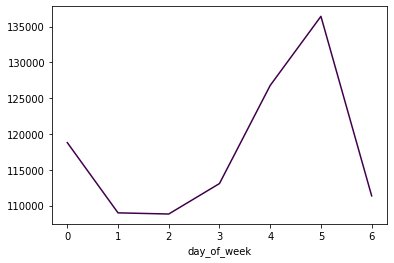

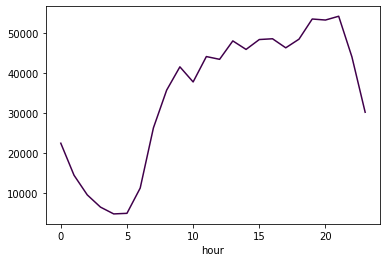

In [289]:
# train.groupby('holiday').ETA.count().plot(kind='bar', cmap='PRGn')
# plt.show()
train.groupby('day_of_week').ETA.count().plot(cmap='PRGn')
plt.show()
train.groupby('hour').ETA.count().plot(cmap='PRGn')
plt.show()

In [204]:
train.groupby(['pickup_cluster', 'OrderedDate_date'], as_index=False).ETA.count()

,pickup_cluster,OrderedDate_date,ETA
0,0,2020-01-20,179
1,0,2020-01-21,208
2,0,2020-01-22,205
3,0,2020-01-23,246
4,0,2020-01-24,367
...,...,...,...
4580,119,2020-03-12,289
4581,119,2020-03-13,249
4582,119,2020-03-14,372
4583,119,2020-03-15,273


In [205]:
train.shape

(798353, 32)

In [206]:
groupby_cols = ['main_id_locality', 'OrderedDate_date', 'hour']
train.merge(train.groupby(['main_id_locality', 'OrderedDate_date', 'hour'],
              as_index=False).ETA.count().rename({'ETA': 'hour_flow'}, axis=1),
            on=groupby_cols, how='left').shape

(798353, 33)

In [0]:
def add_clusters_day_flow(df):
  groupby_cols = ['pickup_cluster', 'OrderedDate_date']
  temp = df.groupby(groupby_cols, as_index=False)\
              .ETA.count().rename({'ETA': 'cluster_day_flow'}, axis=1)
  res = df.merge(temp, on=groupby_cols, how='left')
  assert df.shape[0] == res.shape[0]
  # del df
  # return res
  df['cluster_day_flow'] = df.merge(temp, on=groupby_cols)['cluster_day_flow']

In [0]:
# add_clusters_day_flow(train)
# valid = add_clusters_day_flow(valid)
# test = add_clusters_day_flow(test)

In [0]:
def add_hour_flow(df):
  groupby_cols = ['main_id_locality', 'OrderedDate_date', 'hour']
  temp = df.groupby(groupby_cols, as_index=False)\
              .ETA.count().rename({'ETA': 'hour_flow'}, axis=1)
  res = df.merge(temp, on=groupby_cols, how='left').reset_index()
  idx = df.index
  assert df.shape[0] == res.shape[0]
  # del df
  return res

In [0]:
# valid.drop(['hour_flow', 	'cluster_day_flow',], inplace=True, axis=1)
# test.drop(['hour_flow', 	'cluster_day_flow',], inplace=True, axis=1)
# train.drop([ 	'cluster_day_flow',], inplace=True, axis=1)


In [0]:
# train_1 = add_hour_flow(train)
# valid = add_hour_flow(valid)
# test = add_hour_flow(test)

In [0]:
# sum(train_1.index == train.index)

### OneHotEncoding of cities
Переведем метки городов OneHotEncoding

In [212]:
pd.get_dummies(train['main_id_locality'], prefix='location', prefix_sep='_')

,location_1078,location_22390,location_22430,location_22438
Id,,,,
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
831219,0,0,0,1
831220,0,0,0,1
831221,0,0,0,1


In [0]:
def encode_cities(df):
  dummies = pd.get_dummies(df['main_id_locality'], prefix='location', prefix_sep='_')
  return df.merge(dummies, left_index=True, right_index=True).drop(columns=['main_id_locality'])

In [0]:
train = encode_cities(train)
valid = encode_cities(valid)
test = encode_cities(test)

### Data output
Last checkpoint of preprocessing


In [0]:
drop_cols += ['center_latitude', 'center_longitude']

In [0]:
assert valid.shape[1] == train.shape[1] == (test.shape[1] + 1)

In [0]:
# train.index.name = valid.index.name = test.index.name = 'Id'

In [0]:
from sklearn.preprocessing import scale, StandardScaler

In [0]:
cities = [col for col in train.columns if 'location_' in col]
def scale_coords(df):
  lst = ['latitude', 'longitude', 'del_latitude', 'del_longitude',
         'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca0']
  for city in cities:
    for par in lst:
      df[par][df[city] == 1] = scale(np.array(df[par][df[city] == 1]))

In [240]:
scale_coords(train)
scale_coords(valid)
scale_coords(test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithC

In [241]:
train.head(5)

,ETA,RTA,OrderedDate,latitude,del_latitude,longitude,del_longitude,EDA,center_latitude,center_longitude,route,route_steps,haversine_dist,manhattan_dist,angle,ready_time,collcted_time,ready_collected_dif,OrderedDate_local,hour,day_of_week,hour_of_week,day_of_month,holiday,OrderedDate_date,pickup_cluster,dropoff_cluster,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1,location_1078,location_22390,location_22430,location_22438
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,226.0,188.0,2020-02-12 19:12:06+03:00,0.894129,0.872610,-0.198997,-0.311704,1.0,55.794388,49.111531,gnvsIaq{jHChA??uC???OPG^F^NRzKBd@AN[r@???`@`@`...,29.0,0.475936,0.522207,-95.879608,2.450000,3.000000,0.550000,2020-02-12 19:12:06+03:00,19,2,67,12,0,2020-02-12,83,83,0.005226,-0.718199,-0.129636,-0.025526,1,0,0,0
1,718.0,725.0,2020-02-12 19:12:22+03:00,-0.000943,0.735455,-0.255365,-0.521256,5.0,55.794388,49.111531,sqpsI}~zjHyAr]e@lMk@fLaBlb@i@rLKhBCdAUxEGlCg@f...,78.0,2.999397,3.832401,-19.603279,6.683333,7.333333,0.650000,2020-02-12 19:12:22+03:00,19,2,67,12,0,2020-02-12,2,21,-0.285903,-0.104252,-0.395904,-0.025087,1,0,0,0
2,612.0,764.0,2020-02-12 19:12:44+03:00,-0.131512,0.707553,1.487592,0.586587,5.0,55.794388,49.111531,auosI}mmkH?LHd@KhC??o@w@[g@m@iAUk@??{G|OiB`Ek@...,79.0,4.458880,6.305716,-43.843021,2.616667,2.683333,0.066667,2020-02-12 19:12:44+03:00,19,2,67,12,0,2020-02-12,8,39,1.630580,0.704824,0.825433,-0.003309,1,0,0,0
3,1560.0,1412.0,2020-02-12 19:12:44+03:00,-1.221150,0.846165,0.795723,-0.912909,13.0,55.794388,49.111531,{lhsIiffkHmKN_C?mIPwMJ??Si@gA{B??Wq@MRCJTp@hAd...,164.0,9.853176,13.803791,-36.946603,6.266667,6.416667,0.150000,2020-02-12 19:12:44+03:00,19,2,67,12,0,2020-02-12,25,54,0.578971,1.196151,-0.802724,-0.036014,1,0,0,0
4,1528.0,893.0,2020-02-12 19:12:45+03:00,0.786832,-0.267775,-1.404638,-0.012411,9.0,55.794388,49.111531,yxusI{xnjHgAfG??}IuHkAqA??pIoe@VsA??dAkG`BuH??...,130.0,6.107029,8.606808,130.378310,3.783333,4.683333,0.900000,2020-02-12 19:12:45+03:00,19,2,67,12,0,2020-02-12,11,49,-1.370801,-1.137194,-0.080026,0.016613,1,0,0,0


In [0]:
# third_version
train.drop(columns=drop_cols).to_csv(path + 'train_clean.csv')
valid.drop(columns=drop_cols).to_csv(path + 'valid_clean.csv')
test.drop(columns=drop_cols).to_csv(path + 'test_clean.csv')

# Model


В конечном счете была выбрана сверточная нейронная сеть со следующей архитектурой:

Так же были протестированы различные градиентные бустинги:
  - [Catboost](https://colab.research.google.com/drive/13DulU3M8QTLnHru92CGxT5bMe5gj4-NO#scrollTo=WedDV4jNUWWy).
  - LightGBM
  - XGBoost

In [0]:
# Neuronetwork fitting